# Deep Convolutional Neural Networks for Accurate detection of Coronavirus through chest CT screening



In [ ]:
from google.colab import drive
drive.mount('/content/drive')       #Mounting drive to load images from drive

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/AllTiff/Open"

v10.tif  v13.tif  v16.tif  v20.tif  v22.tif  v25.tif  v28.tif  v7.tif
v11.tif  v14.tif  v17.tif  v21.png  v23.tif  v26.tif  v29.tif  v8.tif
v12.tif  v15.tif  v19.tif  v21.tif  v24.tif  v27.tif  v6.tif   v9.tif


In [ ]:
!ls "/content/drive/MyDrive/AllTiff/Closed"
baseloc = "/content/drive/MyDrive/COVID tif images/"

In [ ]:
!ls "/content/drive/MyDrive/AllTiff/Open"

# Libraries needed

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image 
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from google.colab.patches import cv2_imshow
import os,io,cv2,shutil

# Function to create the crucial CSV file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive'

In [ ]:
import shutil 
# shutil.move('/content/drive/MyDrive/AllTiff/normal10','/content/drive/MyDrive/AllTiff/COVID-CTset/normal10')

In [ ]:
!ls '/content/drive/MyDrive/AllTiff/COVID-CTset' #COVID-CTset'

# Function to get all location of images

In [ ]:
#function to iterate in unzipped covidset folder
import os
from PIL import Image
from tqdm import tqdm
listofalltif = []                                                  # will collect image location of all tif images 
folder = "./"                                                      # if your current directory has the images
folder = "/content/drive/MyDrive/AllTiff/COVID-CTset"                 # or your unzipped folder 'Covidset' location
for result in tqdm(os.listdir(folder)):                                  # result = Normal or Covid 1,2,3
    # if 'covid' in result:                                        # filtering only positive results... hash this to consider all result 
        result = folder+'/'+result                                  
        for patient in os.listdir(result):                         # looping inside each result patient folder then inside each SR folder to get images
                patient = result+'/'+patient
                for hospital in os.listdir(patient):               # hospital can be inferred as individuals with unique 'scan thickness' patient only 
                    hospital = patient+'/'+hospital
                    for ctscan in os.listdir(hospital):            # ctscan is the lung image handling individual thickness of scan
                        if ctscan[-3:] == "tif" :
                            imgloc = hospital+'/'+ctscan           # unique location of the image
                            listofalltif.append(str(imgloc))       # collecting the unique location of all tif in a single list 
                                
                        else:
                            print(result,patient,hospital,ctscan)
        # break
        

In [ ]:
import numpy as np
from tqdm import tqdm
listcroppedshape = []
listimg = []
listcolsavg = []
listrowsavg = []
listmaximat2b = []
listmaximal2r = []
# t=0

for i in tqdm(df[0]):
    if i[-3:] =='tif':
        img                    = Image.open(i) 
        img                    = np.asarray(img)
        h,w                    = img.shape                                                                   # shape
        flattened              = img.flatten()
        listimg.append(flattened)

        cols                   = img.mean(axis=0)                                                            # average from left to right
        rows                   = img.mean(axis=1)                                                            # average from top to bottom
        c,r                    = list(cols), list(rows)                                                      # All values of the histogram are collected in separate list
        listcolsavg.append(cols)
        listrowsavg.append(rows)

        h1,h2,h3               = max(c[:h//3]),max(c[h//3:2*h//3]),max(c[2*h//3:])                           # Maxima is spotted in a range of initial and final 33% percent length(Vertically) of the image 
        w1,w2,w3               = max(r[:w//3]),max(r[w//3:2*w//3]),max(r[2*w//3:])                           # Maxima is spotted in a range of initial and final 33% percent length(Horizontally) of the image
        maximat2b,maximal2r    = (c.index(h1),c.index(h2),c.index(h3)),(r.index(w1),r.index(w2),r.index(w3)) # Location is traced( in terms of pixel) for each maxima which is crucial to start and end the cropping
        listmaximat2b.append(maximat2b)
        listmaximal2r.append(maximal2r)

        imgcropped             = img[maximal2r[0]:maximal2r[2],maximat2b[0]:maximat2b[2]]                    # First l2r then t2b
        listcroppedshape.append(imgcropped.shape)
        # t+=1
        # if t>5:
            # break

In [ ]:
z.to_csv('check.csv')
from google.colab import files
files.download('check.csv')

# Loading the CSV file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive'

In [ ]:
!ls '/content/drive/MyDrive/AllTiff/' #/COVID-CTset'

In [ ]:
# run the first cell for all libraries
c = pd.read_csv('/content/drive/MyDrive/AllTiff/covid.csv')
covid = c.copy()
covid.head()

,Unnamed: 0,loc,img,maximat2b,maximal2r,colsavg,rowsavg,croppedshape
0,0,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(99, 245, 427)","(152, 235, 378)",[ 42.36914062 43.45117188 44.63671875 46.08...,[ 20.10351562 20.0703125 20.02148438 20.02...,"(226, 328)"
1,1,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(101, 244, 424)","(160, 263, 374)",[ 41.29101562 42.37695312 43.78125 45.46...,[ 20.45703125 20.61523438 20.64257812 20.85...,"(214, 323)"
2,2,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 274, 343)","(151, 249, 375)",[ 41.86914062 42.98632812 44.26171875 45.70...,[ 19.7109375 19.89257812 19.96875 20.38...,"(224, 174)"
3,3,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 254, 378)","(150, 271, 369)",[ 41.3515625 42.203125 43.56640625 45.07...,[ 19.66992188 19.734375 20.0703125 20.19...,"(219, 209)"
4,4,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(93, 261, 434)","(148, 218, 379)",[ 43.41601562 44.4375 45.24023438 46.55...,[ 18.31835938 18.38476562 18.59179688 18.67...,"(231, 341)"


# Important Unit Functions 

In [ ]:

#1
def objtolist(sample):
    '''
    sample is the list of input of "object or string" which needs to convert into list of values
    returns the list of int values
    '''
    onelist=[]
    finalist=[]
    strings=''
    for j in tqdm(range(len(sample))):
        for i in sample[j]:
            try:
                first = int(i)
                strings+=i
            except:
                if i==',' :
                    onelist.append(int(strings))
                    strings=''
                elif i==']'or i==')':
                    onelist.append(int(strings))
                    strings=''
                    finalist.append(onelist)
                    onelist=[]

    return finalist


#2
def pixelslist(imglist,mode='central',normalization="True"):
    '''
    imglist : list of location of images to calculate the avg pixel intensity API
    mode : 
    'full' will calculate API for whole image
    'central' will calulate API for 25%-75% of images' size
    normalization:
    numpy/max value
    '''

    if mode=='full':
        percent = 1
    else:
        percent = 0.5        

    a, b = (1-percent)/2,(1+percent)/2

    counts   = 0
    countlist=[]
    for img in tqdm(imglist):
        if img[-3:] == 'tif':
            try: # imglist should have the loc of images only
                img  = Image.open(img)
                h,w  = img.height,img.width
                for y in range(int(a*h),int(b*h)):                                #looping the pixel location in image to get the pixel intensity
                    for x in range(int(a*w),int(b*w)):
                        pixels = img.getpixel((x, y))
                        if normalization:
                            max_val=np.amax(img)
                            pixels =pixels/max_val
                        counts+= pixels
                counts = counts/(h*percent*w*percent)
                countlist.append(counts)
                

                
            except:
                    print("something wrong in this image : " ,img)
                    pass 
    return countlist


#3
def findmaxlung(sizes,mode='maxside'):
    '''
    Args : Sizes : are the list of cropped sizes of the lungs after we have passed the images to cropping function which works on avg pixel intensity maxima
            Mode : has three types 1) "area" : lung with largest area covered 2) "peri" : largest perimeter covered 3) "maxside" : largest width and height (can be from different lungs)

    return : index : location(s) of the largest lung
             ModeValue : largest Value as per the Mode

    '''

    if mode == 'peri':
        perilist = []
        for i in tqdm(range(len(sizes))):
            perilist.append(sizes[i][0] + sizes[i][1])
        index,ModeValue = perilist.index(max(perilist)),max(perilist)
        # print("Largest perimeter lung ",index,ModeValue)

        return index,ModeValue

    elif mode == 'area':
        arealist = []
        for i in tqdm(range(len(sizes))):
            arealist.append(sizes[i][0] * sizes[i][1])
            index,ModeValue = arealist.index(max(arealist)),max(arealist)
            # print("Largest area lung ",index,ModeValue)
            
        return index,ModeValue

    else:
        mode = 'maxside'
        widthlist =[]
        heightlist =[]
        for i in tqdm(range(len(sizes))):
            widthlist.append(sizes[i][1]) 
            heightlist.append(sizes[i][0]) 
        maxwidth  = max(widthlist)
        maxheight = max(heightlist)    
        index,ModeValue   = [heightlist.index(maxheight),widthlist.index(maxwidth)],[maxheight,maxwidth]

        return index,ModeValue

#4
def threshold(openlist,closedlist,normalization="True"):
    '''
    Args   : openlist   = list of folder containing sample open   lungs
             closedlist = list of folder containing sample closed lungs   
    returns: openpixels = list containing average pixel 
            ,closepixels,threshold
    '''
    openpixels  = pixelslist(openlist,normalization=normalization)                 
    closepixels = pixelslist(closedlist,normalization=normalization)

    openmean   = sum(openpixels)/len(openpixels)
    closedmean = sum(closepixels)/len(closepixels)
    threshold  = (openmean+closedmean)/2                # One way to calculate the threshold         89 %
    threshold  =  min(threshold,max(openpixels))        # Second way to calculate the threshold      92 %
                                                        # Third way is to median                     94 %
    return openpixels,closepixels,threshold



#5 
def cropping (imglist,destfold='', view='False',croptype = 'False',):
    '''
    Args    
    imglist =  
    
    croptype ="True" will save the cropped images
                "False" will keep the size same and blackout rest part
    
    destfold = Destination folder where you want to save the cropped images
    viewcrop = Do you want to see the cropped images.. might hang the system

    return : A list of index and "location of the cropped images"
    '''
    AllTiff   = list(covid['loc'])
    for j in (imglist):
        
        try: 
            i         = AllTiff.index(j)
            img       = Image.open(j)                                                 # Loading the image
            img       = np.array(img)                                                 # Converting the image into numpy
            maximal2r = covid['maximal2r'][i]
            maximat2b = covid['maximat2b'][i]
            maximal2r = objtolist(maximal2r)
            maximal2r = maximal2r[0]
            maximat2b = objtolist(maximat2b)
            maximat2b = maximat2b[0]
            X = (w//2)- maximal2r[1]
            Y = 0 #(h//2)- maximat2b[1]                                         # dislocation of center : X,',',Y

        except:
            print('Images are problematic')
        if croptype:
            mask          = np.zeros(img.shape[:2], np.uint8)                   # create a mask
            mask[maximal2r[0]:maximal2r[2],maximat2b[0]:maximat2b[2]] = 255     # check this 
            masked_img   = cv2.bitwise_and(img,img,mask = mask)                 # cropping only part
            # shiftingby = np.float32([[1,0,X], [0,1,Y]])                       # shifting
            # shiftedimg = cv2.warpAffine(masked_img, shiftingby,(X, Y))        # check this
            
        else:
            masked_img= img[maximal2r[0]:maximal2r[2],maximat2b[0]:maximat2b[2]] # cropping and check this 
            mask      = np.zeros(img.shape[:2], np.uint8)  
            # shiftingby = np.float32([[1,0,X], [0,1,Y]]) 
            # shiftedimg = cv2.warpAffine(masked_img, shiftingby,(X, Y))        # check this
            

        if view:
            plt.subplot(221), plt.imshow(img, 'gray'),
            plt.subplot(222), plt.imshow(mask,'gray'),
            plt.subplot(223), plt.imshow(masked_img, 'gray'),
            # plt.subplot(224), plt.imshow(shiftedimg, 'gray')
            plt.xlim([0,512])

            plt.show()

        if destfold:

            try:
                
                # cv2.imwrite(imglist[i][-7:-3]+str(jpeg), masked_img)                         # save in jpeg format
                cropimg = Image.fromarray(masked_img)
                cropimg.save(imglist[i][-7:]) 
                shutil.move(imglist[i][-7:],destfold)
                Outputlist =list(os.listdir(destfold))
            except:
                print("something wrong in destination folder")
                print("images saved at current workind directory")
                Outputlist =os.getcwd()
        else:
            Outputlist =os.getcwd()

        
    return Outputlist

#6
def segregate (pixellist,threshold):
    '''
    Args : pixellist is the list of avg pixel intensity count of all tif images
            threshold is the value which will be considered to bifurcate
    return: two list open and closed with index values in each 

    '''
    openseg = []
    closedseg=[]
    for j,i in tqdm(enumerate(pixellist)):
        if i<threshold:
            openseg.append([j,i])
        else:
            closedseg.append([j,i])
    
    return openseg,closedseg


#7
def listinfolder (folderloc):
    '''
    Args  : folderloc
    return: A list of exact location of each file inside the folder 
    '''
    out   = []
    items = os.listdir(folderloc)
    for i in items:
        out.append(str(folderloc)+'/'+str(i))

    return out

#8
def savelist (listopen,listclosed,destfold=''):
    '''
    Args  : listopen list of all open images listclosed list of all closed images
            destfold folder where to dump open and closed
    return: copy images from AllTiff into two folders named open and closed
    '''
    if destfold:
        pass
    else:
        destfold = os.getcwd()

    for i in listopen:
        shutil.copy(i,str(destfold)+'/'+'OPEN')
    for j in listclosed:
        shutil.copy(j,str(destfold)+'/'+'CLOSED')

    counto = len(str(destfold)+'/'+'OPEN')
    countc = len(str(destfold)+'/'+'CLOSED')
    return {"Open":counto , "Closed":countc } 



# Detailed Analysis of csv

# 1) Cropped shapes

In [ ]:
dff = covid['croppedshape']
dff = objtolist(dff)

heights =[]
width   =[]
for k in dff[:]:
    heights.append(k[0])
    width.append(k[1])

hh = pd.DataFrame(heights)
ww = pd.DataFrame(width)


print(ww.value_counts())
print(hh.value_counts())

100%|██████████| 63849/63849 [00:00<00:00, 79536.46it/s]

172    2375
173    1083
174     993
175     768
176     731
       ... 
131       1
129       1
123       1
498       1
114       1
Length: 382, dtype: int64
172    3492
173    1404
174     912
175     778
176     691
       ... 
421       1
166       1
344       1
427       1
446       1
Length: 221, dtype: int64


In [ ]:
hh.describe(percentiles=[.8,.9,.95,.99])

,0
count,63849.000000
mean,222.472349
std,36.209929
min,0.000000
50%,219.000000
80%,255.000000
90%,273.000000
95%,286.000000
99%,315.000000
max,446.000000


In [ ]:
ww.describe(percentiles=[.8,.9,.95,.99])

,0
count,63849.000000
mean,288.587433
std,76.421073
min,0.000000
50%,300.000000
80%,359.000000
90%,383.000000
95%,401.000000
99%,430.000000
max,511.000000


# Considering both Open and closed lungs 

# 90% of lungs are having height under 383Pixels irrespective of starting width

# 95% of lungs are having height under 401Pixels irrespective of starting width

# 95% of lungs are having width under 286 pixels irrespective of starting height

# Mode value of height and width are 173 pixels

# Subtracting 401 & 286 gives 115 pixels

# 2) Maximas of Avg Pixel intensity

In [ ]:
t2b = covid['maximat2b']
l2r = covid['maximal2r']
t2b = objtolist(t2b)
l2r = objtolist(l2r)
t2b = pd.DataFrame(t2b)
l2r = pd.DataFrame(l2r)

100%|██████████| 63849/63849 [00:01<00:00, 54965.26it/s]


In [ ]:
t2b.describe(percentiles=[.8,.9,.95,.99])

,0,1,2
count,63849.000000,63849.000000,63849.000000
mean,111.332535,260.719917,399.910774
std,41.590925,20.883589,41.488274
min,0.000000,135.000000,40.000000
50%,104.000000,263.000000,407.000000
80%,164.000000,275.000000,438.000000
90%,169.000000,282.000000,450.000000
95%,169.000000,288.000000,458.000000
99%,169.000000,318.000000,475.000000
max,169.000000,340.000000,511.000000


In [ ]:
l2r.describe(percentiles=[.8,.9,.95,.99])

,0,1,2
count,63849.000000,63849.000000,63849.000000
mean,151.024119,261.806512,373.495435
std,23.703503,61.521404,25.597614
min,0.000000,91.000000,106.000000
50%,164.000000,258.000000,371.000000
80%,169.000000,338.000000,395.000000
90%,169.000000,340.000000,408.000000
95%,169.000000,340.000000,418.000000
99%,169.000000,340.000000,441.000000
max,169.000000,340.000000,499.000000


In [ ]:
t2b.value_counts()

0    1    2  
169  262  341    68
     271  341    58
     267  341    56
     270  341    53
     260  341    53
                 ..
97   262  395     1
156  246  347     1
     244  397     1
97   262  414     1
162  239  343     1
Length: 40048, dtype: int64

# 169 & 341 pixel is mostly the first & last maxima spotted t2b

In [ ]:
l2r.value_counts()

0    1    2  
169  340  341    176
          342    130
     339  341    130
     338  341    109
     340  349     96
                ... 
159  330  349      1
          353      1
     331  346      1
          349      1
0    250  430      1
Length: 33706, dtype: int64

In [ ]:
l2r[0].value_counts()

169    22597
168     3878
167     1940
166     1418
165     1164
       ...  
1          1
51         1
18         1
35         1
29         1
Name: 0, Length: 133, dtype: int64

# 169 & 341 pixel is mostly the first & last maxima spotted l2r

# View

In [ ]:
# imgloc = covid['loc'][1234]
# img = Image.open(imgloc)
for i,imgloc in enumerate(covid['loc']):
    # print(imgloc)
    if i == 4000 :    
        img = Image.open(imgloc)                            #Loading the image
        img = np.array(img)                                 #Converting the image into numpy
        plt.imshow(img , 'gray')                            #Show the image as gray
        print(i)
h,w = img.shape
print(h,w)


# Open lungs and closed lungs segregated                    
#Open lungs cropped

In [ ]:
img = covid['loc'][0]
print(img)
#function to convert in numpy 
#function to unflatten
# plt.imshow(img,'gray')

# Cropping and algining

In [ ]:
maximal2r = covid['maximal2r'][i]
maximat2b = covid['maximat2b'][i]
maximal2r = objtolist(maximal2r)
maximal2r = maximal2r[0]
maximat2b = objtolist(maximat2b)
maximat2b = maximat2b[0]

# print(maximal2r,maximat2b)

In [ ]:
X = (w//2)- maximal2r[1]
Y = 0 #(h//2)- maximat2b[1]
print("dislocation of center :", X,',',Y)

In [ ]:
# create a mask
mask = np.zeros(img.shape[:2], np.uint8)
mask[maximal2r[0]:maximal2r[2],maximat2b[0]:maximat2b[2]] = 255     #check this 
masked_img = cv2.bitwise_and(img,img,mask = mask)
shiftingby = np.float32([[1,0,X], [0,1,Y]]) 
shiftedimg = cv2.warpAffine(masked_img, shiftingby,(X, Y))          # check this
# cv2.imwrite('shiftedimg.jpg', shiftedimg) 

plt.plot(221), plt.imshow(img, 'gray')
plt.show()
plt.plot(222), plt.imshow(mask,'gray')
plt.show()
plt.plot(223), plt.imshow(masked_img, 'gray')
plt.show() 
plt.plot(224), plt.imshow(shiftedimg, 'gray')
plt.show()

plt.subplot(221), plt.imshow(img, 'gray'),
plt.subplot(222), plt.imshow(mask,'gray'),
plt.subplot(223), plt.imshow(masked_img, 'gray'),
plt.subplot(224), plt.imshow(shiftedimg, 'gray')
plt.xlim([0,512])

plt.show()


# Segregation Function

In [ ]:
!ls '/content/drive/MyDrive/closed'

In [ ]:
!ls '/content/drive/MyDrive/unnormalized_open_closed_CT'

closed	open


# Sample scans in a separate folder were collected to find the threshold

In [ ]:
#load folder open and closed and images
openloc,closedloc      = '/content/drive/MyDrive/unnormalized_open_closed_CT/open' , '/content/drive/MyDrive/unnormalized_open_closed_CT/closed'
openlist,closedlist    = listinfolder(openloc) , listinfolder(closedloc)

opnpxl, clsdpxl, thresh = threshold(openlist,closedlist,normalization=False)


# Analysing the pixels

In [ ]:
opndf,clsddf  =  pd.DataFrame(opnpxl),pd.DataFrame(clsdpxl)
opndf.describe([.8,.9,.95,.99])

,0
count,100.000000
mean,679.967260
std,50.985354
min,620.518237
50%,663.655365
80%,732.726371
90%,760.036941
95%,773.546783
99%,792.369661
max,853.680479


In [ ]:
clsddf.describe([.30,.8,.9,.95,.99])

,0
count,100.000000
mean,901.247024
std,93.701939
min,730.627576
30%,800.073208
50%,919.000499
80%,996.602453
90%,1003.093155
95%,1031.268795
99%,1045.524592


# Suggested threshold finding method 

# Pick the 99% value of open lungs and pick the (average-standard deviation) value of closed lungs then average this both 

In [ ]:
openvalue = 792.369661
closedvalue= 901.247024-93.701939-93.701939
thresh = (openvalue+closedvalue)/2

In [ ]:
thresh

753.1064034999999

In [ ]:
thresh= 753.1064034999999

Testing function

In [ ]:
listpxl=clsdpxl+opnpxl

In [ ]:
len(listpxl)

200

In [ ]:
opn, clsd   =  segregate (pixellist=listpxl,threshold=thresh)
print('')
print('')
print('As per threshold value ',thresh)
print("Open  lungs  are: " ,len(opn))
print("Closed lungs are: " ,len(clsd))

In [ ]:
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculating normalizing pixel for random 100

In [ ]:
parts  = list(covid['loc'][-10:])
# pxls   = pixelslist(parts)

In [ ]:
for img in tqdm(parts):
    print(img)


100%|██████████| 10/10 [00:00<00:00, 28513.28it/s]

/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00032.tif
/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00002.tif
/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00034.tif
/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00024.tif
/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00043.tif
/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00018.tif
/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00016.tif
/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00039.tif
/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00009.tif
/content/drive/MyDrive/AllTiff/COVID-CTset/normal2/patient296/SR_3/IM00015.tif


# Preprocessing

In [ ]:
!ls '/content/drive/MyDrive/'

00to15.csv  30to45.csv	allcentralpixel.csv  closed
15to30.csv  45to65.csv	AllTiff		     open


Load all avg pixel value

In [ ]:
allpxl = pd.read_csv('/content/drive/MyDrive/allcentralpixel.csv')
print(len(allpxl))
listpxl = []
for i in allpxl['0']:  
  listpxl.append(i)
len(listpxl)

63849


63849

In [ ]:
thresh= 753.1064034999999

# Calculate threshold value

In [ ]:
opn, clsd   =  segregate (pixellist=listpxl,threshold=thresh)
print('')
print('')
print('As per threshold value ',thresh)
print("Open  lungs  are: " ,len(opn))
print("Closed lungs are: " ,len(clsd))


63849it [00:00, 1753377.52it/s]



As per threshold value  753.1064034999999
Open  lungs  are:  39930
Closed lungs are:  23919


In [ ]:
opnidx = []
for i in opn:
    opnidx.append(i[0])

4

# Anlaysis

In [ ]:
allpxl.describe([.7,.8,.9,.95])

# Step 2 Analyzing Open

In [ ]:
covid.head()

,Unnamed: 0,loc,img,maximat2b,maximal2r,colsavg,rowsavg,croppedshape
0,0,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(99, 245, 427)","(152, 235, 378)",[ 42.36914062 43.45117188 44.63671875 46.08...,[ 20.10351562 20.0703125 20.02148438 20.02...,"(226, 328)"
1,1,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(101, 244, 424)","(160, 263, 374)",[ 41.29101562 42.37695312 43.78125 45.46...,[ 20.45703125 20.61523438 20.64257812 20.85...,"(214, 323)"
2,2,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 274, 343)","(151, 249, 375)",[ 41.86914062 42.98632812 44.26171875 45.70...,[ 19.7109375 19.89257812 19.96875 20.38...,"(224, 174)"
3,3,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 254, 378)","(150, 271, 369)",[ 41.3515625 42.203125 43.56640625 45.07...,[ 19.66992188 19.734375 20.0703125 20.19...,"(219, 209)"
4,4,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(93, 261, 434)","(148, 218, 379)",[ 43.41601562 44.4375 45.24023438 46.55...,[ 18.31835938 18.38476562 18.59179688 18.67...,"(231, 341)"


In [ ]:
indx

In [ ]:
pxls = []
indx = []
for i in opn:
  indx.append(i[0])
  pxls.append(i[1])

dfindx        = pd.DataFrame(indx)
dfpxls        = pd.DataFrame(pxls)
opencrp       = covid['croppedshape'][indx]
opencrp       = objtolist(opencrp)
openloc       = covid['loc']
openmaximat2b = covid['maximat2b'][indx]
opencrp       = objtolist(openmaximat2b)
openmaximal2r = covid['maximal2r'][indx]
opencrp       = objtolist(openmaximal2r)

dfopencrp,dfopenloc,dfopenmaximat2b,dfopenmaximal2r = pd.DataFrame(opencrp ),pd.DataFrame( openloc),pd.DataFrame(openmaximat2b ),pd.DataFrame(openmaximal2r )
dfopenloc = dfopenloc['loc'][indx]

100%|██████████| 1/1 [00:00<00:00, 26.08it/s]


In [ ]:
t2b = covid['maximat2b']
l2r = covid['maximal2r']
t2b = objtolist(t2b)
l2r = objtolist(l2r)
t2b = pd.DataFrame(t2b)
l2r = pd.DataFrame(l2r)
# t2b = t2b.iloc[indx]
# l2r = l2r.iloc[indx]

100%|██████████| 63849/63849 [00:01<00:00, 56877.99it/s]


In [ ]:
t2b.describe()

,0,1,2
count,63849.000000,63849.000000,63849.000000
mean,111.332535,260.719917,399.910774
std,41.590925,20.883589,41.488274
min,0.000000,135.000000,40.000000
25%,78.000000,250.000000,358.000000
50%,104.000000,263.000000,407.000000
75%,158.000000,273.000000,433.000000
max,169.000000,340.000000,511.000000


In [ ]:
l2r.describe()

,0,1,2
count,63849.000000,63849.000000,63849.000000
mean,151.024119,261.806512,373.495435
std,23.703503,61.521404,25.597614
min,0.000000,91.000000,106.000000
25%,138.000000,205.000000,352.000000
50%,164.000000,258.000000,371.000000
75%,169.000000,332.000000,391.000000
max,169.000000,340.000000,499.000000


In [ ]:
dfopenmaximal2r.describe()

,maximal2r
count,20094
unique,10393
top,"(169, 340, 341)"
freq,100


In [ ]:
full = pd.read_csv('drive/MyDrive/Full.csv')

# Step3 Crop & save

In [ ]:
full.head()

,Unnamed: 0,Unnamed: 0.1,loc,img,maximat2b,maximal2r,colsavg,rowsavg,croppedshape,maxnpfull,FullAvgPxlDen,CrpdAvgPxlDen,CentAvgPxlDen
0,0,0,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(99, 245, 427)","(152, 235, 378)",[ 42.36914062 43.45117188 44.63671875 46.08...,[ 20.10351562 20.0703125 20.02148438 20.02...,"(226, 328)",2191,439,622,672
1,1,1,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(101, 244, 424)","(160, 263, 374)",[ 41.29101562 42.37695312 43.78125 45.46...,[ 20.45703125 20.61523438 20.64257812 20.85...,"(214, 323)",3039,475,583,634
2,2,2,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 274, 343)","(151, 249, 375)",[ 41.86914062 42.98632812 44.26171875 45.70...,[ 19.7109375 19.89257812 19.96875 20.38...,"(224, 174)",2212,424,885,895
3,3,3,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 254, 378)","(150, 271, 369)",[ 41.3515625 42.203125 43.56640625 45.07...,[ 19.66992188 19.734375 20.0703125 20.19...,"(219, 209)",2291,476,1031,1031
4,4,4,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(93, 261, 434)","(148, 218, 379)",[ 43.41601562 44.4375 45.24023438 46.55...,[ 18.31835938 18.38476562 18.59179688 18.67...,"(231, 341)",2246,348,623,688


In [ ]:
!ls

drive  sample_data


#Declutter

Adding few more columns in covid

In [ ]:
covid['maxnpfull'] = list(covid['Unnamed: 0'])
covid['FullAvgPxlDen'] = list(covid['Unnamed: 0'])
covid['CrpdAvgPxlDen'] = list(covid['Unnamed: 0'])
covid['CentAvgPxlDen'] = list(covid['Unnamed: 0'])

In [ ]:
print(t2b[0][0],t2b[2][0],l2r[0][0],l2r[2][0])

99 427 152 378


In [ ]:
covid['croppedshape'][0]

'(226, 328)'

In [ ]:
central_crop_rectangle=((t2b[0][i],l2r[0][i],t2b[2][i],l2r[2][i]))

In [ ]:
cropped_img

array([[  10,   25,   42, ...,   44,   45,   43],
       [   3,    1,   19, ...,   25,   19,   22],
       [  23,    8,    0, ...,   64,   58,   51],
       ...,
       [ 943,  950,  935, ..., 1071, 1083, 1063],
       [ 921,  929,  918, ..., 1042, 1031, 1008],
       [ 937,  934,  938, ..., 1002,  982,  977]], dtype=uint16)

In [ ]:
immg  = alltiffs[0]
immg  = Image.open(immg)
immg  = immg.crop(crop_rectangle)
cropped_img    = np.array(immg)
cropped_mean   = np.mean(cropped_img)

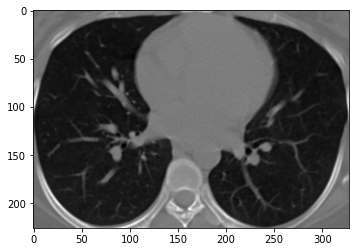

In [ ]:
plt.imshow(cropped_img,'gray')

In [ ]:
alltiffs =[]
for i in covid['loc']:
    alltiffs.append(i)

In [ ]:
len(alltiffs)

63849

In [ ]:
print(mm,cropped_mean)

295.4967460632324 615.678232826556


In [ ]:
tif = Image.open(alltiffs[i[0]])

In [ ]:
covid['maxnpfull'][2] = max_val
covid['FullAvgPxlDen'][2] = mm

In [ ]:
ter = ter[0]

In [ ]:
ter

[0, 672.2747802734375]

In [ ]:
ter =[]
for i in opn:
    ter.append((i))
ter

In [ ]:
covid.head()

In [ ]:
l = [3.14, 'string', ('tuple', 'of', 'items')]
a = (', '.join(map(repr, opn)))
print(a)

[0, 672.2747802734375], [1, 634.1712383236736], [4, 688.0679428068595], [5, 659.161637389264], [9, 646.8837475992342], [11, 628.0168512607654], [12, 663.4386294075206], [16, 669.4416307491756], [18, 642.0544107676114], [20, 632.8622944590297], [21, 667.1703927962411], [22, 660.9937464964721], [23, 644.5276488303604], [24, 637.8998493598757], [25, 734.5598739601038], [26, 642.891945798858], [27, 641.7524244986846], [30, 629.159501459563], [31, 660.8020043869243], [32, 707.0272796936704], [33, 661.4146732678175], [36, 645.2867646563705], [38, 642.8810159189828], [40, 687.126672604792], [41, 640.703249003183], [43, 627.380685223663], [44, 632.5271817121159], [45, 641.4054493283343], [46, 667.9574799415486], [48, 631.3526223618437], [49, 659.1769157809807], [53, 626.5541379380187], [54, 659.2367027914114], [55, 640.0737645981261], [56, 662.4080058863008], [58, 705.5399776190538], [59, 671.0109182735843], [62, 660.2263956962843], [63, 657.9935337279617], [65, 636.1869825234156], [66, 734.01

In [ ]:
 %pprint

Pretty printing has been turned OFF


In [ ]:
for i in tqdm(opn):
  if i[0]>100:
    break  
  else:
    print (i)
  

In [ ]:
opntup = []
for i in opn:
    opntup.append(i[0])


In [ ]:
abc =[]
for i in opn:
  a=covid['Unnamed: 0'][i[0]]
  abc.append(int(a))



In [ ]:
dff = covid['Unnamed: 0'].iloc[opntup]

In [ ]:
# a = dff.index()
a


In [ ]:
for i in tqdm(a):
    if i>1000:
        break
    else:
        print(i)

In [ ]:
a = [index for index, value in enumerate(opntup) ]

In [ ]:
opntup = tuple(opntup)

In [ ]:
a = covid['Unnamed: 0']

In [ ]:
a = a.to_list( )

In [ ]:
len(a)

63849

In [ ]:
a[-1]

63848

In [ ]:
opnindex=[]
for i in opn:
  opnindex.append(i[0])

In [ ]:
opnindex

In [ ]:
len(opnindex)

for i in a:
  pass

In [ ]:
opnidx = []
for i in opn:
    opnidx.append(i[0])

In [ ]:
!ls drive/MyDrive/AllTiff/Open     

v10.tif  v13.tif  v16.tif  v20.tif  v22.tif  v25.tif  v28.tif  v7.tif
v11.tif  v14.tif  v17.tif  v21.png  v23.tif  v26.tif  v29.tif  v8.tif
v12.tif  v15.tif  v19.tif  v21.tif  v24.tif  v27.tif  v6.tif   v9.tif


#Hard Crop in folder Function

In [ ]:
#import the libraries 
imglist=[]
folder = 'drive/MyDrive/AllTiff/Open'                       #location of the folder in which cropping is to be done
destfold= '/content/drive/MyDrive/CroppedHardOpen'          #location of the destination folder where to paste  
for j in os.listdir(folder):
    imglist.append(folder+'//'+j)



for n,i in enumerate(imglist):
    tif  = Image.open(i)
    crop_rectangle          = ((70,127,440,348))         # this is how it will crop margins are: (left, upper, right, lower)
    cropped_img             = tif.crop(crop_rectangle)
    cropped_img.save(destfold+'//'+str(n)+str(i)[-4:])
    break                                               # hash this line to go for all images or test for one without hashing

In [ ]:
crop_rectangle          = ((70,127,440,348))

39930

In [ ]:
tif  = Image.open(alltiffs[int(i)])
array=np.array(tif)

#Saving Insights of images in a CSV for better segregation

In [ ]:
exception = []
for i in tqdm(a):
  
  try:
    i = int(i)
    tif  = Image.open(alltiffs[i])
    array=np.array(tif)
    
    if i in opnindex:
          #1 Cropping cropped shape & #2 saving mean & Visualizing and Saving cropped
          crop_rectangle          = ((t2b[0][i],l2r[0][i],t2b[2][i],l2r[2][i]))
          cropped_img             = tif.crop(crop_rectangle)
          cropped_img             = np.array(cropped_img)
          cropped_mean            = np.mean(cropped_img)
          cropped_max             = np.amax(cropped_img)
          cropped_normalized      = (cropped_img/cropped_max)

          covid['CrpdAvgPxlDen'][i] = cropped_mean
          im = Image.fromarray(cropped_normalized)
          im.save('/content/drive/MyDrive/CroppedOpenLungs/CrpdOpn'+str(i)+alltiffs[i][-4:])


          #3 Cropping centrally & saving mean
          central_crop_rectangle = ((128,128,384,384))
          central_cropped_img    = tif.crop(central_crop_rectangle)
          central_cropped_img    = np.array(central_cropped_img)
          central_cropped_mean   = np.mean(central_cropped_img)
          covid['CentAvgPxlDen'][i] = central_cropped_mean

          #4 max saving
          max_val=np.amax(array)     
          covid['maxnpfull'][i] = max_val

          #5 Saving JPEG
          backtorgb = cv2.cvtColor(array,cv2.COLOR_GRAY2RGB)
          cv2.imwrite('/content/drive/MyDrive/JpegSegregatedOpenLungs/sgr'+covid['loc'][i][-11:-3]+'.jpeg', backtorgb)

          #6 Saving mean &  #7Full visualizable
          m = np.mean(array)
          covid['FullAvgPxlDen'][i] = m
          normalized=(array/max_val)
          im = Image.fromarray(normalized)
          im.save('/content/drive/MyDrive/SegregatedOpenLungsCopied/opn'+str(i)+alltiffs[i][-4:])
    else:
        #1 Cropping cropped shape & #2 saving mean & Visualizing and Saving cropped
        crop_rectangle          = ((t2b[0][i],l2r[0][i],t2b[2][i],l2r[2][i]))
        cropped_img             = tif.crop(crop_rectangle)
        cropped_img             = np.array(cropped_img)
        cropped_mean            = np.mean(cropped_img)
        covid['CrpdAvgPxlDen'][i] = cropped_mean


        #3 Cropping centrally & saving mean
        central_crop_rectangle = ((128,128,384,384))
        central_cropped_img    = tif.crop(central_crop_rectangle)
        central_cropped_img    = np.array(central_cropped_img)
        central_cropped_mean   = np.mean(central_cropped_img)
        covid['CentAvgPxlDen'][i] = central_cropped_mean

        #4 max saving
        max_val=np.amax(array)     
        covid['maxnpfull'][i] = max_val

        #5 Saving JPEG
        backtorgb = cv2.cvtColor(array,cv2.COLOR_GRAY2RGB)
        cv2.imwrite('/content/drive/MyDrive/JpegSegregatedClosedLungs/sgr'+covid['loc'][i][-11:-3]+'.jpeg', backtorgb)

        #6 Saving mean &  #7Full visualizable
        m = np.mean(array)
        covid['FullAvgPxlDen'][i] = m
        normalized=(array/max_val)
        im = Image.fromarray(normalized)
        im.save('/content/drive/MyDrive/SegregatedClosedLungsCopied/cls'+str(i)+alltiffs[i][-4:])
  except:
      exception.append(i)
      print("EXECEPTION",i)

#Using csv

In [ ]:
!ls drive/MyDrive/

allcentralpixel.csv  CroppedHardOpen   good_crop.rar
AllTiff		     CroppedOpenLungs  put_in_open
bad_crop	     Full.csv	       unnormalized_open_closed_CT


In [ ]:
full = pd.read_csv('drive/MyDrive/Full.csv')
alltiffs = full['loc']

In [ ]:
full['maxnpfull'][2] 
full['FullAvgPxlDen'][2]

424

0
1
2
3
4


In [ ]:
exception = []
for i in tqdm(full['Unnamed: 0']):
  
  try:
    i = int(i)
    tif  = Image.open(alltiffs[i])
    array=np.array(tif)
    
    if i in opnidx:
          #1 Cropping cropped shape & #2 saving mean & Visualizing and Saving cropped
          crop_rectangle          = ((70,127,440,348))
          cropped_img             = tif.crop(crop_rectangle)
          cropped_img             = np.array(cropped_img)
          cropped_max             = full['maxnpfull'][i] 
          cropped_normalized      = (cropped_img/cropped_max)
          im = Image.fromarray(cropped_normalized)
          im.save('/content/drive/MyDrive/CroppedHardOpen/CrpdOpn'+str(i)+alltiffs[i][-4:])
          normalized=(array/cropped_max)
          im = Image.fromarray(normalized)
          im.save('/content/drive/MyDrive/SegregatedOpenLungsCopied/opn'+str(i)+alltiffs[i][-4:])
    else: 
        #6 Saving mean &  #7Full visualizable
        cropped_max             = full['maxnpfull'][i]
        normalized              = (array/cropped_max)
        im = Image.fromarray(normalized)
        im.save('/content/drive/MyDrive/SegregatedClosedLungsCopied/cls'+str(i)+alltiffs[i][-4:])
  except:
      exception.append(i)
      print("EXECEPTION",i)

100%|██████████| 63849/63849 [6:09:29<00:00,  2.88it/s]


In [ ]:
covid.head()

,Unnamed: 0,loc,img,maximat2b,maximal2r,colsavg,rowsavg,croppedshape,maxnpfull,FullAvgPxlDen,CrpdAvgPxlDen,CentAvgPxlDen
0,0,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(99, 245, 427)","(152, 235, 378)",[ 42.36914062 43.45117188 44.63671875 46.08...,[ 20.10351562 20.0703125 20.02148438 20.02...,"(226, 328)",2191,439,622,672
1,1,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(101, 244, 424)","(160, 263, 374)",[ 41.29101562 42.37695312 43.78125 45.46...,[ 20.45703125 20.61523438 20.64257812 20.85...,"(214, 323)",3039,475,583,634
2,2,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 274, 343)","(151, 249, 375)",[ 41.86914062 42.98632812 44.26171875 45.70...,[ 19.7109375 19.89257812 19.96875 20.38...,"(224, 174)",2212,424,885,895
3,3,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 254, 378)","(150, 271, 369)",[ 41.3515625 42.203125 43.56640625 45.07...,[ 19.66992188 19.734375 20.0703125 20.19...,"(219, 209)",2291,476,1031,1031
4,4,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(93, 261, 434)","(148, 218, 379)",[ 43.41601562 44.4375 45.24023438 46.55...,[ 18.31835938 18.38476562 18.59179688 18.67...,"(231, 341)",2246,348,623,688


In [ ]:
#Cropping open lungs and saving in HardCropOpenLungs folder
crop_rectangle = ((70,127,440,348))
for i in tqdm((dfopenloc)):
  img = Image.open(i)
  cropped_img    = img.crop(crop_rectangle)
  cropped_img.save('crp'+i[-11:])
  shutil.move('crp'+i[-11:] , '/content/drive/MyDrive/HardCropOpenLungs/crp'+i[-11:])
  # plt.imshow(img,'gray')


In [ ]:

plt.imshow(Image.open(strngs+'yes.tiff'),'gray')


#Largest lung side wise

In [ ]:
dff = list(covid['croppedshape'])

In [ ]:
dff = objtolist(dff)

In [ ]:
a, b = findmaxlung(dff)
print("SIDES",a,b)

In [ ]:
for i,imgloc in enumerate(covid['loc']):
    # print(imgloc)
    if i == a[0] :    
        img = Image.open(imgloc)                            #Loading the image
        img = np.array(img)                                 #Converting the image into numpy
        plt.imshow(img , 'gray')                            #Show the image as gray
        print("Maximum height is derived from lung no.", a[0],"with value of ",b[0], "pixel")

This means firstly we need to crop and align the lungs and then again see their dimensions

In [ ]:
for i,imgloc in enumerate(covid['loc']):
    # print(imgloc)
    if i == a[1] :    
        img = Image.open(imgloc)                            #Loading the image
        img = np.array(img)                                 #Converting the image into numpy
        plt.imshow(img , 'gray')                            #Show the image as gray
        print("Maximum width is derived from lung no.", a[1],"with value of ",b[1], "pixel")

#Largest lung area wise

In [ ]:
a, b = findmaxlung(dff,mode='area')
print(a,b)

In [ ]:
aaa = covid['loc'].iloc[56874]
img = Image.open(aaa)
img = np.array(img)
img.shape

In [ ]:
covid['croppedshape'].iloc[56874]

In [ ]:
a, b = findmaxlung(dff,mode='peri')
print(a,b)

In [ ]:
for i,imgloc in enumerate(covid['loc']):
    # print(imgloc)
    if i == a :    
        img = Image.open(imgloc)                            #Loading the image
        img = np.array(img)                                 #Converting the image into numpy
        plt.imshow(img , 'gray')                            #Show the image as gray
        print("Maximum area is derived from lung no.", a,"with value of ",b, "sq pixel")

This means firstly we need to crop and align the lungs and then again see their dimensions